# Thresholding

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### simple thresholding

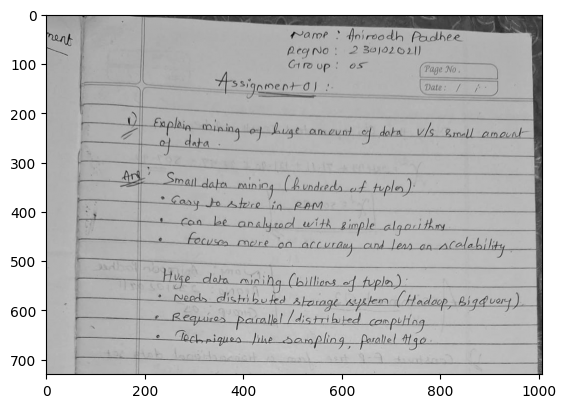

In [3]:
image = cv2.imread('handwriting.jpg')
image_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image_grey,cmap='grey')

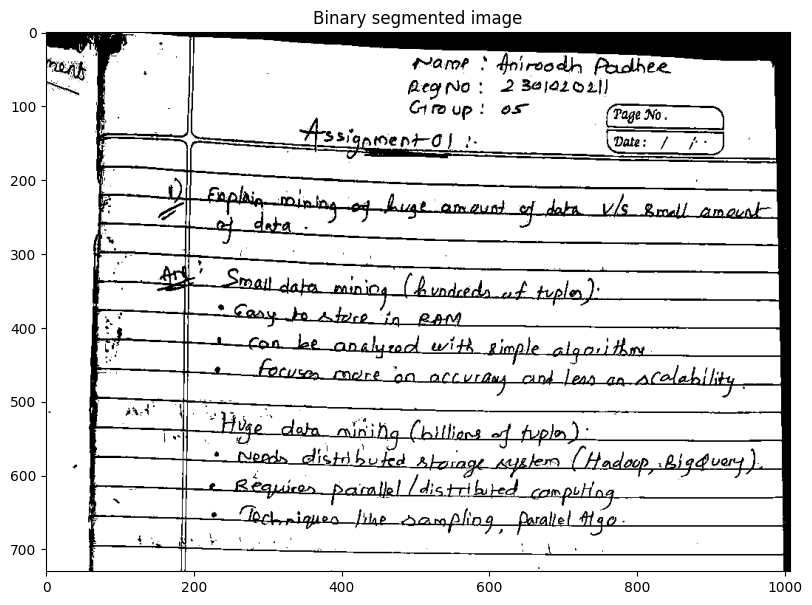

In [5]:
retval, binary = cv2.threshold(image_grey,150,255,cv2.THRESH_BINARY)
plt.figure(figsize=(12,7))
plt.imshow(binary,cmap='grey')
plt.title('Binary segmented image')
plt.show()

### Adaptive thresholding

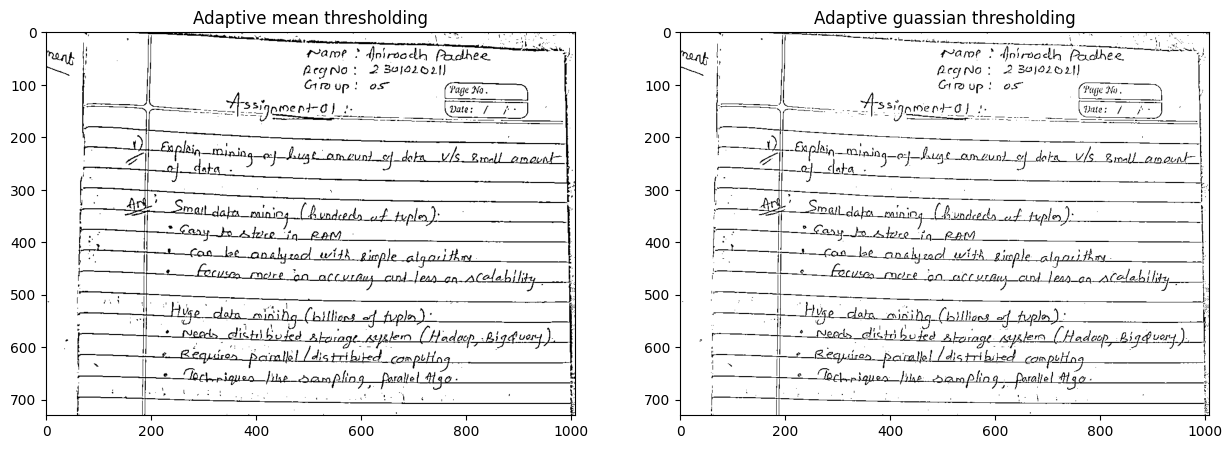

In [18]:
adaptive_m = cv2.adaptiveThreshold(image_grey, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11, 15)
adaptive_g = cv2.adaptiveThreshold(image_grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11, 15)

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.imshow(adaptive_m, cmap='grey')
plt.title("Adaptive mean thresholding")

plt.subplot(1,2,2)
plt.imshow(adaptive_g, cmap='grey')
plt.title("Adaptive guassian thresholding")
plt.show()


# kmeans clustering

In [ ]:
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_pixels = image_rgb.reshape((-1,3))    #### here we are  using rgb image for image segmentation and converting image to its pixel values
image_pixels = np.float32(image_pixels)     #### kmeans clustering always accept float values
print(image_pixels)

[[143. 144. 148.]
 [143. 144. 148.]
 [143. 144. 148.]
 ...
 [ 62. 100. 139.]
 [ 61.  99. 138.]
 [ 55.  89. 127.]]


#### Termination Criteria in OpenCV
When you run iterative algorithms in OpenCV (like k-means clustering, corner refinement, mean-shift, etc.), you need to tell the algorithm when to stop iterating.

OpenCV gives you three options for stopping:

cv2.TERM_CRITERIA_MAX_ITER → stop after a fixed number of iterations.

cv2.TERM_CRITERIA_EPS → stop when the change between iterations is smaller than a threshold (epsilon).

cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER → stop when either condition is met.

#### What is EPS?

EPS = Epsilon (ε)

It’s a small threshold value that defines the minimum accuracy / change needed between iterations.

If the algorithm’s progress (e.g., cluster centers in k-means) becomes smaller than this epsilon, it assumes convergence and stops early.

In [10]:
criteria = (cv2.TermCriteria_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3

_, labels, centers = cv2.kmeans(image_pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [11]:
print(labels.shape)
print(centers)

(735110, 1)
[[124.35338 123.28845 133.15714]
 [167.60878 167.5964  173.37001]
 [ 55.17702  70.82391  99.12024]]


#### labels → tells you which cluster each data point belongs to.
#### centers → the final cluster centers 
 

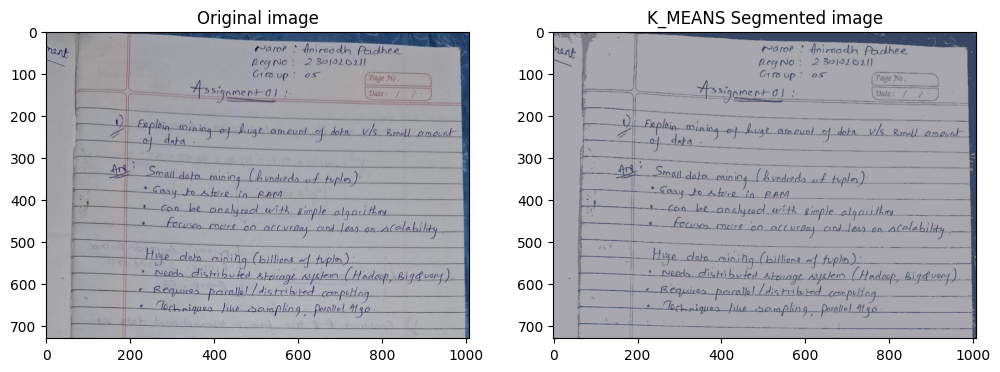

In [ ]:
centers = np.uint8(centers)   ### converting all the centers back to integer

# Replace pixels with cluster centers
segmented_image = centers[labels.flatten()]    
segmented_image = segmented_image.reshape(image_rgb.shape)   #### converting the pixel form of image to real image

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("K_MEANS Segmented image")

plt.show()

# watershed algorithm

#### STEP_01:-
cv2.imread loads BGR.

Convert to RGB so matplotlib shows correct colors.

Keep a copy() for drawing results later (so you don’t mutate the one you use for processing).

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

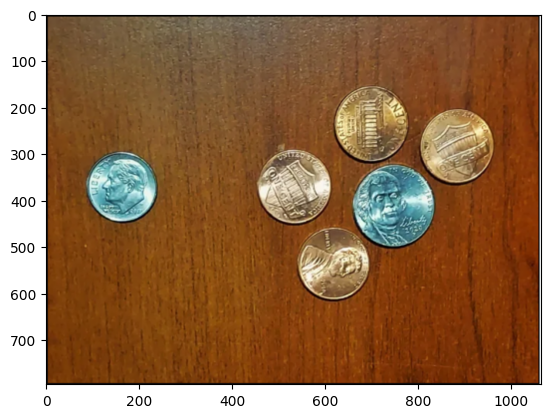

In [4]:
image = cv2.imread('coin.png')
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
original_image = image.copy()
plt.imshow(image_rgb)

#### step_02
Watershed wants seeds (markers) for “sure foreground” and “sure background.”

Grayscale simplifies to intensity.

THRESH_BINARY_INV with threshold 130 → bright coins on dark background become white (255); background becomes black (0) after inversion.

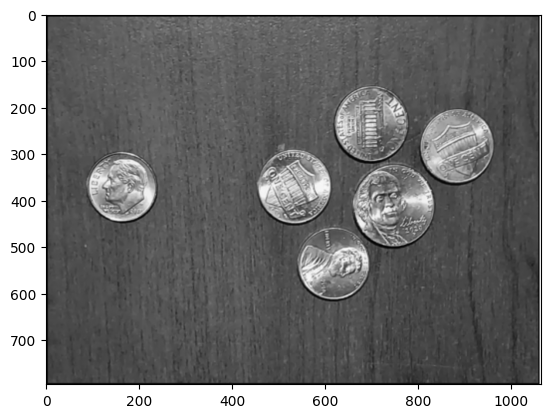

In [6]:
image_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image_grey,cmap='grey')

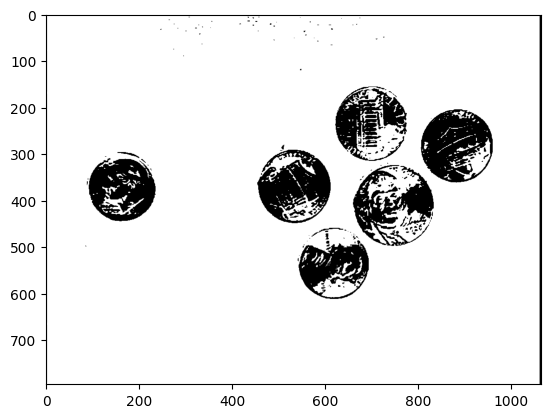

In [ ]:
#### performing the thresholding

_,thresh = cv2.threshold(image_grey,130,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='grey')

#### step_03
Opening = erosion then dilation.

Removes salt noise (tiny white specks), keeps coin blobs.

iterations=4 = fairly aggressive; increases smoothness but can shrink thin parts.

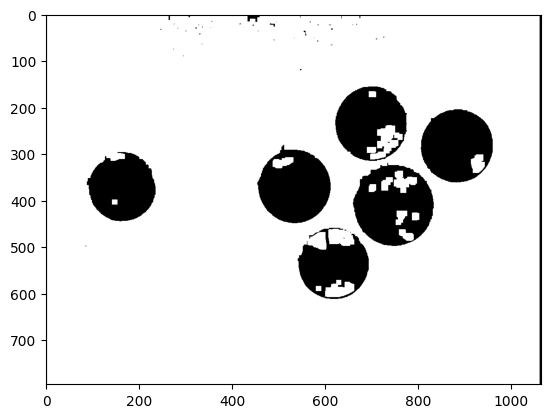

In [11]:
#### noiw we want to clear the noises in the image, for that we need perform morphology, and to perfrom the cleaning we need to create a kernel

kernel = np.ones((3,3),np.uint8)
openings = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=5)

plt.imshow(openings,cmap='grey')


#### step_04
#### ✅ Sure Foreground

Meaning: Pixels that we are certain belong to the object (inside region).

Usually obtained by:

Applying morphological erosion (shrinks objects) → removes uncertain boundary pixels.

Or using distance transform (pixels farthest from the background are most “sure” to be inside).

👉 Example: If we segment coins in an image:

The center of each coin (away from edges) is “sure foreground”.

#### ✅ Sure Background

Meaning: Pixels that we are certain belong to the background (outside region).

Usually obtained by:

Applying morphological dilation (expands background)

Or thresholding (e.g., Otsu) to confidently pick non-object areas.

👉 Example with coins:

The black area around the coins is “sure background”.

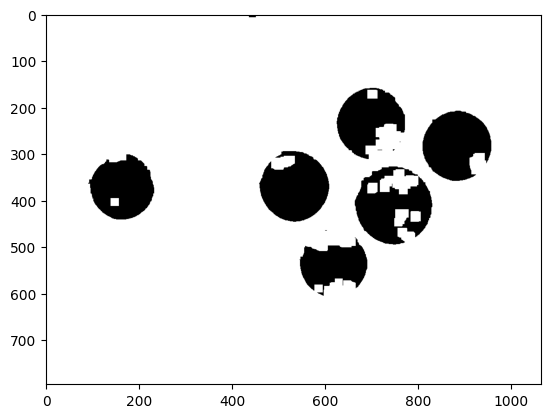

In [12]:
sure_bg = cv2.dilate(openings,kernel,iterations=3)
plt.imshow(sure_bg,cmap='grey')

#### step_05
#### Distance Transform assigns each pixel in a binary image a value = distance to the nearest zero (black pixel).

Pixels inside the coin centers will have higher values (farther from the background).

Pixels near the edges will have lower values.

So you end up with a gradient-like image, where coin centers are bright and edges are darker.

#### Why L2 and 5?

cv2.DIST_L2 → Euclidean distance (straight-line distance).

5 → mask size (affects how precisely distance is computed).

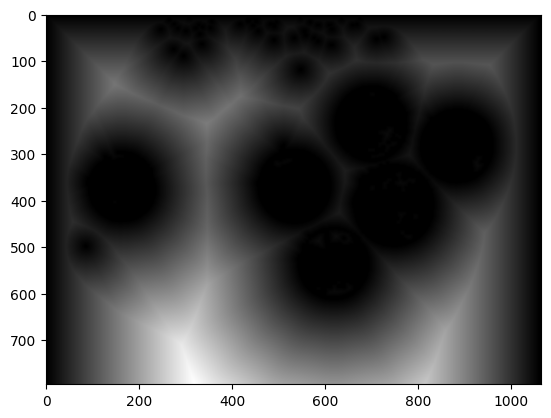

In [13]:
dist_transform = cv2.distanceTransform(openings,cv2.DIST_L2,5)
plt.imshow(dist_transform,cmap='grey')

#### What it does: Thresholding

From the distance map, we want to find the “sure foreground” (the core of the coins).

Take the maximum distance value (dist_transform.max()) → that’s the brightest center.

Multiply by 0.3 → keep only pixels with distance > 30% of max (the inner, safe coin region).

Threshold result → binary mask where coin centers are white, everything else is black.

#### Why this step?

We don’t want to risk mislabeling the edges (where coins touch).

By keeping only the core, we ensure each coin gets at least one seed marker for the watershed algorithm to grow from.

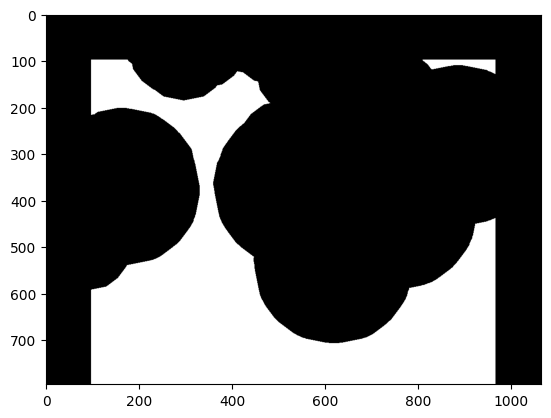

In [14]:
_,sure_fg = cv2.threshold(dist_transform,0.3 * dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

plt.imshow(sure_fg, cmap='grey')

#### step_06 ---> finding the unknnown
Pixels we’re not sure about (likely the borders between touching coins).

Watershed will place boundaries here.

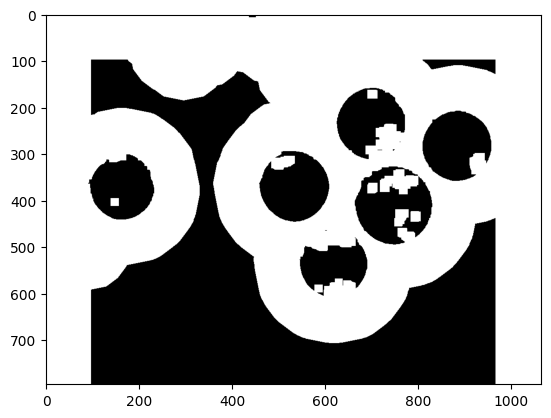

In [15]:
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap='grey')

#### step_06
connectedComponents assigns a unique integer label to each foreground blob (1..N).

+1 shifts them so that background becomes 1 instead of 0.

Set unknown pixels to 0 → watershed starts flooding from labeled seeds, treating 0 as unlabeled.

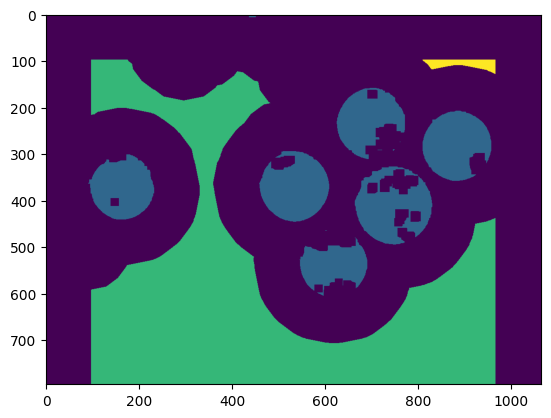

In [16]:
_,markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

plt.imshow(markers)

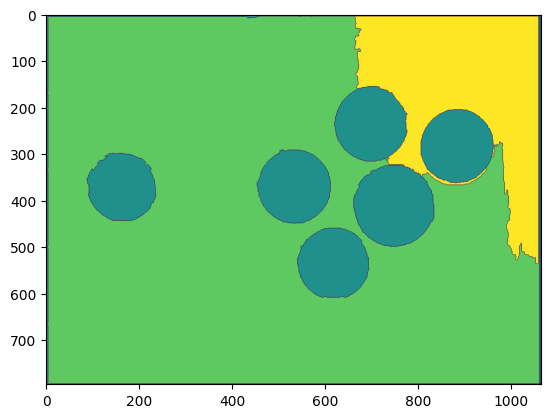

In [17]:
markers = cv2.watershed(image_rgb,markers)
plt.imshow(markers)

In [24]:
original_image = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

In [25]:
coin_mask = np.zeros_like(image_grey)

print(image_grey.shape)
print(coin_mask.shape)

unique_labels = np.unique(markers)

instance_number = 1
font = cv2.FONT_HERSHEY_SIMPLEX

for label in unique_labels:
    if label == 0 or label == -1:
        continue

    mask = np.uint8(markers == label)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimerter = cv2.arcLength(contour,True)

        if perimerter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimerter * perimerter))

        if 0.7 < circularity < 1.2 and area > 1000:
            cv2.drawContours(original_image, [contour], -1, (0,255,0), 2)
            x, y, w, h = cv2.boundingRect(contour)
            cv2.putText(original_image, f'Coin {instance_number}', (x, y-10), font, 0.6, (255,0, 0), 2)
            coin_mask = cv2.bitwise_or(coin_mask, mask)
            cv2.rectangle(original_image,(x-5, y-5), (x+w+5, y+h+5), (160, 150, 250), 2)
            instance_number += 1


(796, 1066)
(796, 1066)


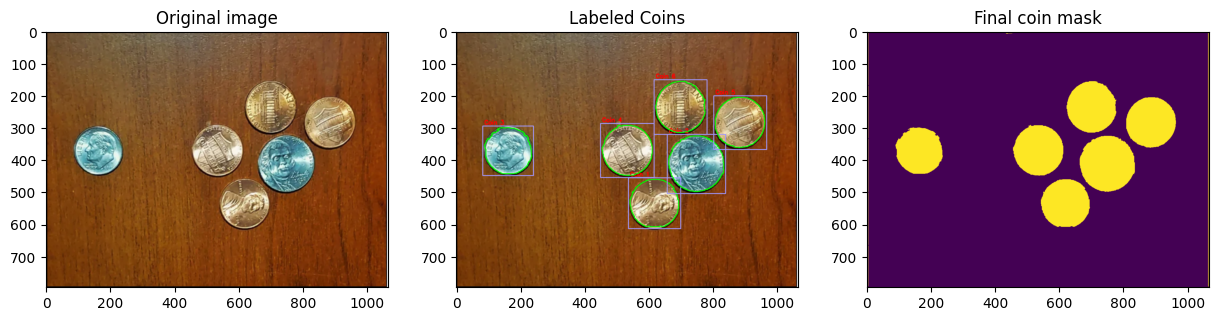

In [26]:
plt.figure(figsize=(15,10))


plt.subplot(1,3,1)
plt.imshow(image_rgb)
plt.title("Original image")

plt.subplot(1,3,2)
plt.imshow(original_image)
plt.title("Labeled Coins")

plt.subplot(1,3,3)
plt.imshow(coin_mask)
plt.title("Final coin mask")

plt.show()